# Updated HDP HMM Evaluation Pipeline

In [2]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import torch
import numpy as np
from sklearn.model_selection import train_test_split

import logging

# Configure logging
logging.basicConfig(
    filename="hdp_training.log",  # output file name
    filemode="a",                 # append mode ("w" for overwrite)
    format="%(asctime)s - %(message)s",
    level=logging.INFO
)


def train_hdp(
    num_states,
    group_data,
    obs_dim,
    test_data=None,
    num_steps=3000,
    patience=500,
    min_delta=1e-3,
    verbose=True
):
    pyro.clear_param_store()

    elbo_trace = []
    best_loss = float("inf")
    patience_counter = 0

    def model(groups):
        gamma = torch.tensor(1.0)
        beta_k = pyro.sample("beta_k", dist.Beta(1., gamma).expand([num_states]).to_event(1))
        beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)

        mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
        sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

        for g, seq in enumerate(groups):
            alpha = torch.tensor(1.0)
            pi = pyro.sample(f"pi_{g}", dist.Dirichlet(alpha * beta[:-1]))
            with pyro.plate(f"obs_{g}", seq.shape[0]):
                z = pyro.sample(f"z_{g}", dist.Categorical(pi), infer={"enumerate": "parallel"})
                pyro.sample(f"x_{g}", dist.Normal(mus[z], sigmas[z]).to_event(1), obs=seq)

    def guide(groups):
        beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
        pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

        mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
        mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
        pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

        sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
        pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

        for g in range(len(groups)):
            beta_k_q = pyro.param("beta_k_q")
            pi_alpha = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
            pyro.sample(f"pi_{g}", dist.Dirichlet(pi_alpha))

    svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

    for step in range(num_steps):
        loss = svi.step(group_data)
        elbo_trace.append(loss)

        if verbose and step % 100 == 0:
            print(f"[{step}] Loss: {loss:.2f} (ELBO: {-loss:.2f})")

        if loss + min_delta < best_loss:
            if step != 0 and loss == best_loss:
                # Avoid logging same loss repeatedly
                continue
            best_loss = loss
            patience_counter = 0
            msg = f"New best loss at step {step}: {loss}"
            print(msg)
            logging.info(msg)
        else:
            patience_counter += 1
            msg = f"No improvement at step {step} (current loss: {loss}, best: {best_loss}) [patience={patience_counter}]"
            #print(msg)
            logging.info(msg)




        if patience_counter >= patience:
            print(f"Stopping early at step {step}, no improvement for {patience} steps.")
            break

    # --- Count active states ---
    beta_k_q = pyro.param("beta_k_q")
    pi_values = []
    
    for g in range(len(group_data)):
        pi_alpha = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])[:-1]
        pi = dist.Dirichlet(pi_alpha).mean  # Use the mean of the variational Dirichlet
        pi_values.append(pi)

    avg_pi = torch.stack(pi_values).mean(dim=0)
    active_states = (avg_pi > 0.01).sum().item()

    # --- Predictive log-likelihood (if test set provided) ---
    predictive_ll = None
    if test_data is not None:
        with torch.no_grad():
            mus = pyro.param("mus_loc")
            sigmas = pyro.param("sigmas_scale")
            test_lls = []
            for seq in test_data:
                log_probs = dist.Normal(mus, sigmas).log_prob(seq.unsqueeze(1))  # [T, K, D]
                test_lls.append(log_probs.sum(-1).logsumexp(dim=1).mean().item())
            predictive_ll = np.mean(test_lls)

    return {
        "elbo_trace": elbo_trace,
        "best_elbo": -best_loss,  # Use negative best loss as final ELBO
        "active_states": active_states,
        "predictive_loglik": predictive_ll
    }


In [1]:
import matplotlib.pyplot as plt

# Split your group data into training and testing groups (if needed)
train_groups, test_groups = train_test_split(group_data, test_size=0.2, random_state=42)

candidate_states = list(range(5,150, 10))  # Finer granularity around promising range
results = []

for k in candidate_states:
    print(f"\nTraining with {k} states...")
    result = train_hdp(k, train_groups, obs_dim=obs_dim, test_data=test_groups)
    results.append((k, result))

# --- Plot Final ELBO and Active States ---
elbos = [r["best_elbo"] for _, r in results]
actives = [r["active_states"] for _, r in results]
predictive_ll = [r["predictive_loglik"] for _, r in results]
state_counts = [k for k, _ in results]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(state_counts, elbos, marker='o')
plt.xlabel("Number of States")
plt.ylabel("Final ELBO")
plt.title("Final ELBO vs. State Count")

plt.subplot(1, 2, 2)
plt.plot(state_counts, actives, marker='s', label="Active States")
plt.plot(state_counts, predictive_ll, marker='^', label="Predictive Log-Likelihood")
plt.xlabel("Number of States")
plt.title("Model Diagnostics")
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'train_test_split' is not defined

In [36]:
max(elbos)

-322678.6319885254

# Pyro HDP-HSMM-Like Code

In [85]:
# get list of ground truth coins
import pandas as pd
path = "../Stempelliste_bueschel_Neuses_einfach.xlsx"
df = pd.read_excel(path, engine='openpyxl')

averse = defaultdict(list)
reverse = defaultdict(list)

ID = df["Dédalo ID"]
A = df["Stempeluntergruppe Av"]
R = df["Stempeluntergruppe Rv"]

for id_val, av, rv in zip(ID, A, R):
    averse[av].append(id_val)
    reverse[rv].append(id_val)
    
averse = {str(k): v for k, v in averse.items()}
truth_coins = list(ID)

In [86]:
data["group_names"]

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Prot', 'undefined']

Loaded 3 groups with 223 total coins.
[0] ELBO: 3491759.62
[50] ELBO: 739780.38
[100] ELBO: 20223608.83
[150] ELBO: 37548485089.95
[200] ELBO: 2172090.02
[250] ELBO: 30172931.15
[300] ELBO: 2886787015.85
[350] ELBO: 144047182.26
[400] ELBO: 108301293.91
[450] ELBO: 15907738.43
[500] ELBO: 37544998.51
[550] ELBO: 67974436.45
[600] ELBO: 875641.19
[650] ELBO: 34083445.36
[700] ELBO: 38586916.79
[750] ELBO: 555907.38
[800] ELBO: 1469290.05
[850] ELBO: 18207920.71
[900] ELBO: 214367.10
[950] ELBO: 463608077.26
[1000] ELBO: 601929.74
[1050] ELBO: 3130278.57
[1100] ELBO: 36710821.37


/tmp/ipykernel_1825/380592542.py:166: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(group_data))


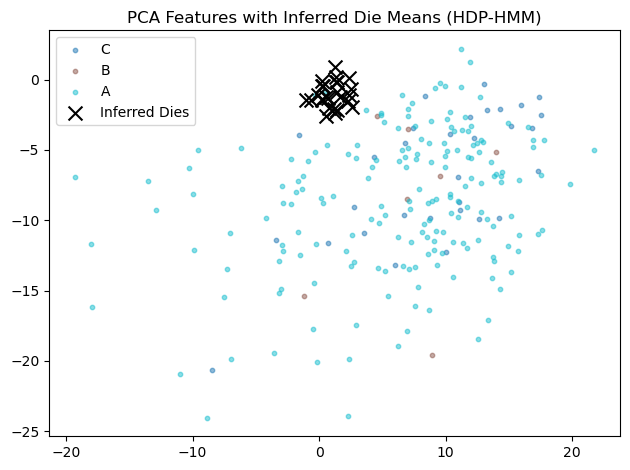

In [87]:
import pickle
import torch
from collections import defaultdict
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
# HDP-HMM over groups (each group emits all its coins from a single die)
import pyro
import pyro.distributions as dist
import torch
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


# Setup
pyro.clear_param_store()
torch.manual_seed(0)
device = torch.device("cpu")

# Load saved features
#with open("coin_features_pca_coin_clip.pkl", "rb") as f:
#    data = pickle.load(f)

with open("coin_features_pca_coin_clip.pkl", "rb") as f:
    data = pickle.load(f)


# filter for ground truth coins
import numpy as np
# Get the indices of rows to keep
keep_indices = [
    i for i, path in enumerate(data["paths"])
    if int(path.split("/")[-1].split("_")[0]) in truth_coins
]
#Filter all fields in the dict using these indices
filtered_data = {
    "features": data["features"][keep_indices],
    "labels": [data["labels"][i] for i in keep_indices],
    "paths": [data["paths"][i] for i in keep_indices],
    "group_names": data["group_names"],
}
data = filtered_data



features = data["features"]
labels = data["labels"]
obs_dim = features.shape[1]


# Group features by label
grouped_features = defaultdict(list)
for feat, label in zip(features, labels):
    grouped_features[label].append(feat)

# Convert to torch tensors
group_data = [torch.tensor(v, dtype=torch.float32) for v in grouped_features.values()]
group_names = list(grouped_features.keys())

print(f"Loaded {len(group_data)} groups with {sum(len(g) for g in group_data)} total coins.")

# Ensure all are float32



# Hyperparameters
alpha_val = 10
gamma_val = 10
#num_states = 200
#num_states = 82
num_states = 26
obs_dim = group_data[0].shape[1] # dimensionality of feature vectors

# Example group data with 3 groups and 5-dimensional features (dummy structure)
#group_data = [torch.randn(100, obs_dim), torch.randn(120, obs_dim), torch.randn(80, obs_dim)]

def model(groups):
    gamma = torch.tensor(gamma_val)
    beta_k = pyro.sample("beta_k", dist.Beta(1., gamma).expand([num_states]).to_event(1))
    beta = torch.cat([beta_k, 1 - beta_k.sum().unsqueeze(0)], dim=0)

    mus = pyro.sample("mus", dist.Normal(torch.zeros(num_states, obs_dim), 5.0).to_event(2))
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(num_states, obs_dim)).to_event(2))

    # Transition matrix between states (dies)
    with pyro.plate("states", num_states):
        A = pyro.sample("A", dist.Dirichlet(alpha_val * beta[:-1]))

    z_prev = pyro.sample("z_0", dist.Categorical(beta[:-1]))

    for g, group in enumerate(groups):
        if g > 0:
            z_prev = pyro.sample(f"z_{g}", dist.Categorical(A[z_prev]))

        pi_g = pyro.sample(f"pi_{g}", dist.Dirichlet(alpha_val * beta[:-1]))

        with pyro.plate(f"obs_{g}", group.shape[0]):
            z_ng = pyro.sample(f"z_ng_{g}", dist.Categorical(pi_g))
            pyro.sample(f"x_{g}", dist.Normal(mus[z_ng], sigmas[z_ng]).to_event(1), obs=group)

def guide(groups):
    beta_k_q = pyro.param("beta_k_q", lambda: torch.rand(num_states), constraint=dist.constraints.unit_interval)
    #beta_k_q = pyro.param(
    #    "beta_k_q",
    #    lambda: torch.full((num_states,), 0.8),
    #    constraint=dist.constraints.unit_interval
    #)
    pyro.sample("beta_k", dist.Delta(beta_k_q).to_event(1))

    mus_loc = pyro.param("mus_loc", lambda: torch.randn(num_states, obs_dim))
    mus_scale = pyro.param("mus_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("mus", dist.Normal(mus_loc, mus_scale).to_event(2))

    sigmas_scale = pyro.param("sigmas_scale", lambda: torch.ones(num_states, obs_dim), constraint=dist.constraints.positive)
    pyro.sample("sigmas", dist.HalfCauchy(sigmas_scale).to_event(2))

    A_q = pyro.param("A_q", lambda: torch.ones(num_states, num_states), constraint=dist.constraints.simplex)
    with pyro.plate("states", num_states):
        pyro.sample("A", dist.Delta(A_q).to_event(1))


    z0_q = pyro.param("z0_q", lambda: torch.ones(num_states), constraint=dist.constraints.simplex)
    pyro.sample("z_0", dist.Categorical(z0_q))

    for g, group in enumerate(groups):
        pi_q = pyro.param(f"pi_q_{g}", lambda: torch.ones(num_states), constraint=dist.constraints.simplex)
        pyro.sample(f"pi_{g}", dist.Delta(pi_q).to_event(1))
    
        if g > 0:
            z_q = pyro.param(f"z_{g}_q", lambda: torch.ones(num_states), constraint=dist.constraints.simplex)
            #z_q = pyro.param(
            #    f"z_q_{g}",
            #    lambda: torch.ones(group.shape[0], num_states) * (1.0 / num_states),
            #    constraint=dist.constraints.simplex
            #)
            pyro.sample(f"z_{g}", dist.Categorical(z_q))
    
        with pyro.plate(f"obs_{g}", group.shape[0]):
            z_q_ng = pyro.param(f"z_q_{g}", lambda: torch.ones(group.shape[0], num_states), constraint=dist.constraints.simplex)
            #z_q_ng = pyro.param(
            #    f"z_q_{g}",
            #    lambda: torch.ones(group.shape[0], num_states) * (1.0 / num_states),
            #    constraint=dist.constraints.simplex
            #)
            pyro.sample(f"z_ng_{g}", dist.Categorical(z_q_ng))


# Just compile the model and guide (you should call this from your training loop)
svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

# Train
num_steps = 1101
for step in range(num_steps):
    loss = svi.step(group_data)
    if step % 50 == 0:
        print(f"[{step}] ELBO: {loss:.2f}")



# Inferred die (state) locations
mus_post = pyro.param("mus_loc").detach().cpu()
colors = plt.cm.get_cmap('tab10', len(group_data))

# Plot group PCA features
for i, (group_tensor, name) in enumerate(zip(group_data, group_names)):
    arr = group_tensor.numpy()
    plt.scatter(arr[:, 0], arr[:, 1], label=name, alpha=0.5, s=10, color=colors(i))

# Plot inferred die means
plt.scatter(mus_post[:, 0], mus_post[:, 1], color='black', marker='x', s=100, label='Inferred Dies')
plt.title("PCA Features with Inferred Die Means (HDP-HMM)")
plt.legend()
plt.tight_layout()
plt.show()


In [88]:
# Step 1: Extract posterior parameters
mus = pyro.param("mus_loc").detach()
sigmas = pyro.param("sigmas_scale").detach()
beta_k_q = pyro.param("beta_k_q").detach()
beta = torch.cat([beta_k_q, 1 - beta_k_q.sum().unsqueeze(0)])  # [num_states + 1]

# Load paths
image_paths = data["paths"]

# Assign image path to die
coin_to_die = []  # updated
idx = 0  # global index across all groups

for g, group in enumerate(group_data):
    pi_alpha = alpha_val * beta[:-1]
    pi_g = dist.Dirichlet(pi_alpha).mean

    log_probs = dist.Normal(mus, sigmas).log_prob(group.unsqueeze(1)).sum(-1) + pi_g.log()
    z_hat = log_probs.argmax(dim=1)

    for z in z_hat:
        coin_to_die.append({
            "group": group_names[g],
            "die_index": z.item(),
            "image_path": image_paths[idx]
        })
        idx += 1

# Now coin_to_die contains (group_name, coin_index, die_index)


In [89]:
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(coin_to_die)

# Save to CSV
output_csv = "coin_die_assignments_groundtruth.csv"
df.to_csv(output_csv, index=False)

print(f"Saved coin-to-die assignments to: {output_csv}")


Saved coin-to-die assignments to: coin_die_assignments_groundtruth.csv


In [90]:
from collections import Counter

# Count how often each die is used
die_counts = Counter([entry["die_index"] for entry in coin_to_die])

# Print top 10 most used dies
print("Top used dies:")
for die, count in die_counts.most_common(10):
    print(f"Die {die}: {count} coins")


Top used dies:
Die 9: 77 coins
Die 0: 73 coins
Die 8: 14 coins
Die 18: 13 coins
Die 12: 8 coins
Die 22: 7 coins
Die 15: 6 coins
Die 20: 4 coins
Die 16: 4 coins
Die 23: 4 coins


In [91]:
len(die_counts)

16

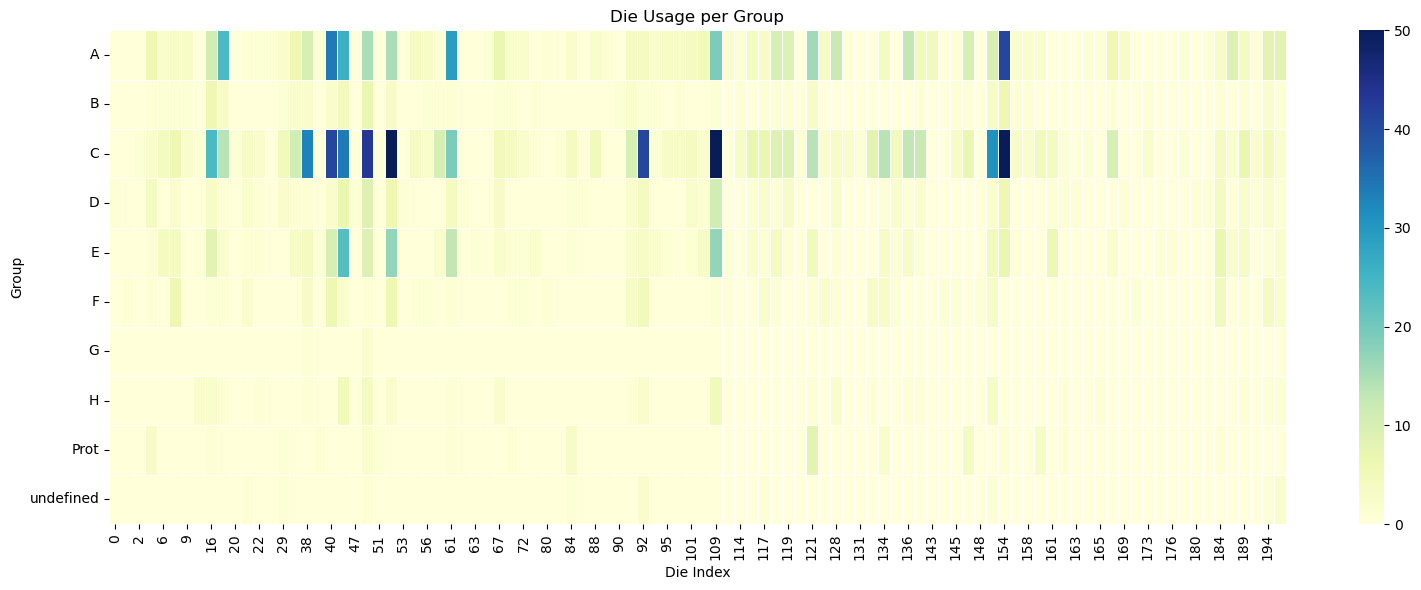

In [78]:
import pandas as pd

# Convert coin_to_die to DataFrame
df = pd.DataFrame(coin_to_die)  # each row should contain 'group' and 'die_index'

# Pivot table: rows = groups, columns = dies, values = count
usage_matrix = df.pivot_table(index="group", columns="die_index", aggfunc="size", fill_value=0)

# Optional: Sort groups if they're chronological (e.g., 'A', 'B', 'C', ...)
usage_matrix = usage_matrix.sort_index()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.heatmap(usage_matrix, cmap="YlGnBu", linewidths=0.5)
plt.title("Die Usage per Group")
plt.xlabel("Die Index")
plt.ylabel("Group")
plt.tight_layout()
plt.show()



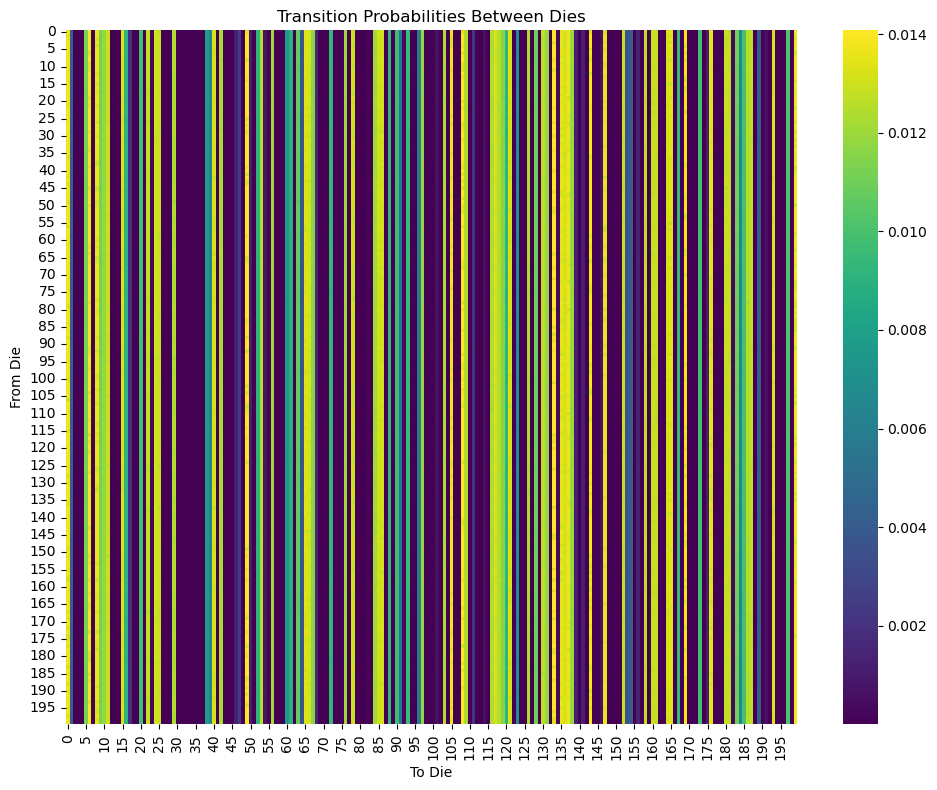

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieve learned transition matrix
A_q = pyro.param("A_q").detach().cpu()  # shape: [num_states, num_states]

plt.figure(figsize=(10, 8))
sns.heatmap(A_q, cmap="viridis", xticklabels=5, yticklabels=5)
plt.title("Transition Probabilities Between Dies")
plt.xlabel("To Die")
plt.ylabel("From Die")
plt.tight_layout()
plt.show()


In [23]:
import openpyxl
from openpyxl.drawing.image import Image as OpenpyxlImage
from openpyxl.utils import get_column_letter

# Assuming you already have coin_to_die list of dicts:
# coin_to_die = [
#     {"group": ..., "die_index": ..., "image_path": ...},
#     ...
# ]

# Create workbook and worksheet
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Coin to Die Data"

# Write header row
headers = ["group", "die_index", "image_path", "image"]
for col_num, header in enumerate(headers, start=1):
    ws.cell(row=1, column=col_num, value=header)

# Starting from second row to write data
for row_num, entry in enumerate(coin_to_die, start=2):
    ws.cell(row=row_num, column=1, value=entry["group"])
    ws.cell(row=row_num, column=2, value=entry["die_index"])
    ws.cell(row=row_num, column=3, value=entry["image_path"])

    # Add image
    try:
        img = OpenpyxlImage(entry["image_path"])

        # Optionally resize images to fit better in cells (adjust as needed)
        max_width = 100  # pixels
        max_height = 100

        # Resize maintaining aspect ratio
        ratio_w = max_width / img.width
        ratio_h = max_height / img.height
        ratio = min(ratio_w, ratio_h, 1)  # Don't upscale images

        img.width = int(img.width * ratio)
        img.height = int(img.height * ratio)

        # Insert image into the 4th column of the current row
        cell_address = f"D{row_num}"
        ws.add_image(img, cell_address)

        # Optionally adjust row height to fit the image
        ws.row_dimensions[row_num].height = img.height * 0.75  # openpyxl uses points

        # Optionally set column width to fit images
        ws.column_dimensions[get_column_letter(4)].width = max_width / 7  # approx width in excel chars

    except FileNotFoundError:
        print(f"Image not found: {entry['image_path']}")
    except Exception as e:
        print(f"Error inserting image for row {row_num}: {e}")

# Save workbook
wb.save("coin_to_die_images_10_features_true_hdp_hsmm__groundtruth_reverse.xlsx")


# Visualization of which die emitted which coin and to which group it belongs

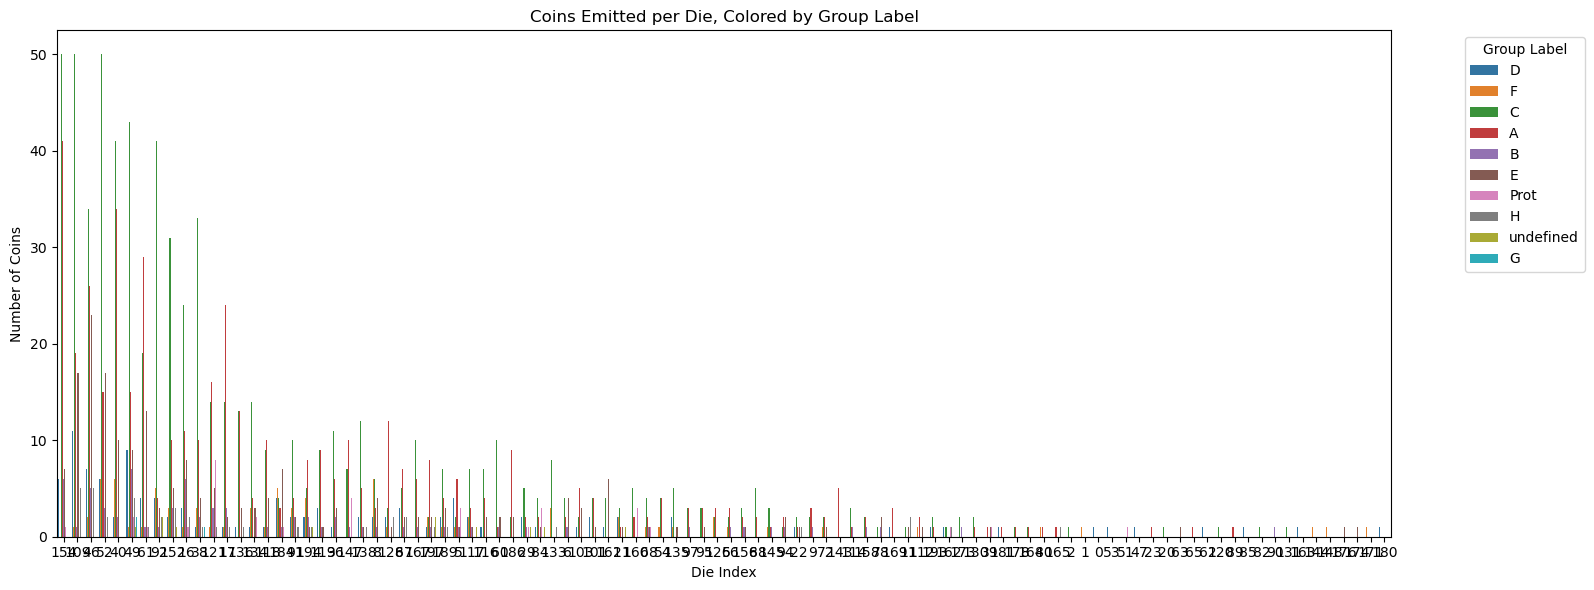

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load assignments
df = pd.read_csv("coin_die_assignments.csv")

# Count number of coins emitted per die per group
counts = df.groupby(["die_index", "group"]).size().reset_index(name="count")

# Sort dies by total coins emitted (optional for cleaner plotting)
total_per_die = counts.groupby("die_index")["count"].sum().sort_values(ascending=False)
ordered_dies = total_per_die.index.tolist()
counts["die_index"] = pd.Categorical(counts["die_index"], categories=ordered_dies, ordered=True)

# Plot
plt.figure(figsize=(16, 6))
sns.barplot(data=counts, x="die_index", y="count", hue="group", dodge=True)

plt.title("Coins Emitted per Die, Colored by Group Label")
plt.xlabel("Die Index")
plt.ylabel("Number of Coins")
#plt.yscale(value="log")
plt.legend(title="Group Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
